In [ ]:
# install category-encoders if not installed
# !pip install category-encoders
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Import data and split feature and label

In [11]:
df = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
col_drop = df.columns[df.nunique()==1]
df.drop(col_drop, axis=1, inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Separate the features from the labels

In [12]:
Xtrain = df.copy()
ytrain = Xtrain.loc[:,['SalePrice']]
Xtrain = Xtrain.drop('SalePrice', axis = 1)
Xtrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Separete the train, validation, and test sets

In [13]:
from sklearn.model_selection import train_test_split

# split train and validation dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, test_size = 0.2, random_state = 42)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size = 0.5, random_state = 42)

# Data Preprocessing

### Separete categorical features and numerical features

In [14]:
# get the binary categorical colums
bin_cols = Xtrain.select_dtypes(include=['object']).columns[Xtrain.select_dtypes(include=['object']).nunique() == 2].tolist()
# get the rest categorical columns
ord_cols = [col for col in Xtrain.columns if col not in bin_cols and Xtrain[col].dtype == 'object']
# get the numerical categorical columns
num_cols = Xtrain.select_dtypes(include=['int64', 'float64']).columns
# ensure the numerical columns have only numerical values
Xtrain[num_cols] = Xtrain[num_cols].apply(pd.to_numeric, errors='coerce')

### Create encoder instances

In [17]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
import category_encoders as ce


std = StandardScaler()
cte = ce.CountEncoder(cols=ord_cols, normalize=True, handle_unknown='value')
ohe = ce.OneHotEncoder(cols=bin_cols, use_cat_names=False, handle_unknown='value')
be = ce.BinaryEncoder(cols=bin_cols)


### Encode the labels

In [18]:
# encode the price with StandardScaler
std_label = StandardScaler()
ytrain_encoded = pd.DataFrame(std_label.fit_transform(ytrain), columns=ytrain.columns)
yval_encoded = pd.DataFrame(std_label.transform(yval), columns = yval.columns)

### Encode the features of train, test and validation sets

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# encoding the features
# one-hot encoding the binary features
Xtrain_encoded = ohe.fit_transform(Xtrain)
Xval_encoded = ohe.transform(Xval)
Xtest_encoded = ohe.transform(Xtest)

Xtrain_encoded = cte.fit_transform(Xtrain_encoded)
Xval_encoded = cte.transform(Xval_encoded)
Xtest_encoded = cte.transform(Xtest_encoded)

Xtrain_scaled = std.fit_transform(Xtrain_encoded[num_cols])
Xtrain_encoded[num_cols] = Xtrain_scaled
Xval_scaled = std.transform(Xval_encoded[num_cols])
Xval_encoded[num_cols] = Xval_scaled
Xtest_scaled = std.transform(Xtest_encoded[num_cols])
Xtest_encoded[num_cols] = Xtest_scaled

In [20]:
Xtrain_encoded.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street_1,Street_2,Alley_1,Alley_2,Alley_3,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,-1.119284,-0.866764,0.791096,-0.013818,-0.212896,1,0,1,0,0,...,-0.275838,-0.070993,0.994863,0.800514,0.960616,-0.09274,-0.133417,1.650065,0.866438,0.825342
1066,0.790464,0.074110,0.791096,-0.455871,-0.265245,1,0,1,0,0,...,-0.275838,-0.070993,0.994863,0.800514,0.960616,-0.09274,-0.508010,0.893677,0.866438,0.825342
638,-0.216152,-0.631546,0.791096,-0.134378,-0.177841,1,0,1,0,0,...,-0.275838,-0.070993,0.994863,0.109589,0.960616,-0.09274,-0.508010,0.137290,0.866438,0.825342
799,0.162505,-0.161109,0.791096,-0.415684,-0.324474,1,0,1,0,0,...,-0.275838,-0.070993,0.994863,0.109589,0.960616,-0.09274,-0.133417,-0.619098,0.866438,0.825342
380,-0.822944,-0.161109,0.791096,-0.817550,-0.529035,1,0,0,1,0,...,-0.275838,-0.070993,0.994863,0.800514,0.960616,-0.09274,-0.508010,1.650065,0.866438,0.825342


# Feature Projection
This step is for reducing the number of features to keep features that are important.

#### PCA projection
There are many ways to do feature selection, here I'll use PCA method.

To be able to apply PCA to reduce the dimension, we need to ensure there are no 'nan' existing in the dataset

To ensure non 'nan' presenting in the datasets, I replace value 'nan' with 0 in features. (This can also be resolved by replacing 'nan' with mean or median)

In [21]:
Xtrain_encoded = Xtrain_encoded.fillna(0)
Xval_encoded = Xval_encoded.fillna(0)
Xtest_encoded = Xtest_encoded.fillna(0)

##### PCA features projection

In [22]:
from sklearn.decomposition import PCA

pca = PCA(None)
Xtrain_pca = pca.fit_transform(Xtrain_encoded)

To determine which features are kept, we need to know the importance of each feature.
We can take account of the proportion of variance in the original (encoded) data that is explained by each principal component of the PCA

In [23]:
variances = [f"{comp:.2%}" for comp in pca.explained_variance_ratio_]
variances

['18.30%',
 '8.53%',
 '6.82%',
 '5.20%',
 '3.95%',
 '3.15%',
 '3.05%',
 '2.97%',
 '2.95%',
 '2.85%',
 '2.78%',
 '2.68%',
 '2.63%',
 '2.60%',
 '2.55%',
 '2.37%',
 '2.27%',
 '2.14%',
 '2.09%',
 '2.00%',
 '1.90%',
 '1.72%',
 '1.61%',
 '1.48%',
 '1.33%',
 '1.09%',
 '1.02%',
 '0.87%',
 '0.75%',
 '0.69%',
 '0.62%',
 '0.53%',
 '0.42%',
 '0.35%',
 '0.30%',
 '0.27%',
 '0.23%',
 '0.22%',
 '0.19%',
 '0.18%',
 '0.17%',
 '0.17%',
 '0.17%',
 '0.15%',
 '0.14%',
 '0.13%',
 '0.12%',
 '0.12%',
 '0.11%',
 '0.10%',
 '0.10%',
 '0.07%',
 '0.07%',
 '0.07%',
 '0.06%',
 '0.06%',
 '0.05%',
 '0.05%',
 '0.05%',
 '0.05%',
 '0.04%',
 '0.04%',
 '0.04%',
 '0.03%',
 '0.03%',
 '0.03%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.02%',
 '0.01%',
 '0.01%',
 '0.01%',
 '0.01%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%',
 '0.00%']

We can visualize the cumulative sum of the explained variance ratio as a function of the number of components to help us to determine the remained number of components.

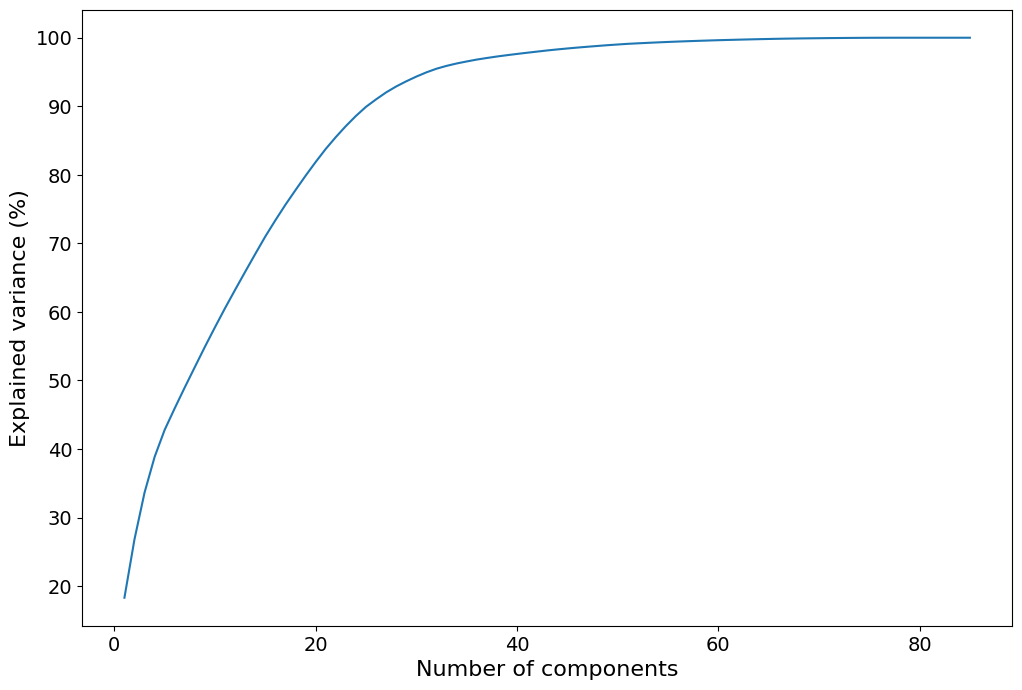

In [24]:

plt.figure(figsize=(12,8))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components", fontsize=16)
plt.ylabel("Explained variance (%)", fontsize = 16)
plt.tick_params(labelsize=14)
plt.show()

##### Feature Projection

In [25]:
# Select 20 principal components with highest explained variance as seen above
# change the number of principal components to optimize model
explained_variances = pca.explained_variance_ratio_
selected_pca_indices = explained_variances.argsort()[::-1][:27]
Xtrain_pca_selected = Xtrain_pca[:, selected_pca_indices]

# create new train, validation, and test datasets with selected features
Xtrain_selected = Xtrain_encoded.iloc[:, selected_pca_indices]
Xval_selected = Xval_encoded.iloc[:, selected_pca_indices]
Xtest_selected = Xtest_encoded.iloc[:, selected_pca_indices]

# Build Model

## Machine Learning Approach
Let's use the gradient boosting regression model to predict the price of a house.

In [26]:
# model setup
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(learning_rate=0.1,
                                      n_estimators=100,
                                      subsample=0.8,
                                      max_depth=10,
                                      random_state=42,
                                      max_features='auto')

## Neural Network Approach
#### Suppose there is a linear relationship between the house price and the features
We can implement non-linear regression in the model during optimization process.

In [71]:
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

### Create the model with TensorFlow

In [77]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
reset_seeds()

def polynomial_activation(x):
  return tf.keras.backend.square(x)

n_features = Xtrain_selected.shape[1]
input = Input(shape=(n_features,))
#dropout1 = Dropout(0.5)(input)
hidden1 = Dense(units = n_features, 
                activation = polynomial_activation, 
                activity_regularizer = tf.keras.regularizers.L2(0.01))(input)
#dropout2 = Dropout(0.5)(hidden1)
hidden2 = Dense(units = n_features//2, 
                activation = 'linear',
                activity_regularizer = tf.keras.regularizers.L2(0.01))(hidden1)
hidden3 = Dense(units = n_features//4, 
                activation = 'linear',
                activity_regularizer = tf.keras.regularizers.L2(0.01))(hidden2)
hidden4 = Dense(units = n_features//4, 
                activation = polynomial_activation,
                activity_regularizer = tf.keras.regularizers.L2(0.01))(hidden3)
output = Dense(units=1, activation = 'linear')(hidden2)

house = Model(inputs=input, outputs = output)
house.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, use_ema=True, ema_momentum=0.99), loss=tf.keras.losses.MSE)

In [78]:
house.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27)]              0         
                                                                 
 dense (Dense)               (None, 27)                756       
                                                                 
 dense_1 (Dense)             (None, 13)                364       
                                                                 
 dense_4 (Dense)             (None, 1)                 14        
                                                                 
Total params: 1,134
Trainable params: 1,134
Non-trainable params: 0
_________________________________________________________________


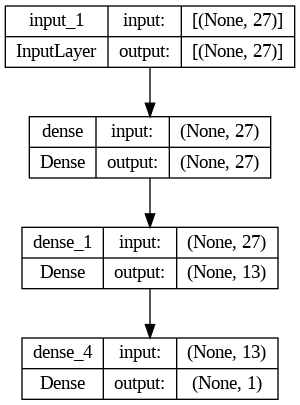

In [79]:
tf.keras.utils.plot_model(house, show_shapes=True)

# Training the model

## Machine Learning Model Training

In [27]:
gbr_model.fit(Xtrain_encoded, ytrain_encoded)

/Users/lin.yang/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lin.yang/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/lin.yang/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To

GradientBoostingRegressor(max_depth=10, max_features='auto', random_state=42,
                          subsample=0.8)

## Neural Netork Model Training

In [80]:
from keras.optimizers.schedules.learning_rate_schedule import LearningRateSchedule

epoch = 500
batch = 64
reset_seeds()

history = house.fit(Xtrain_selected, 
                    ytrain_encoded, 
                    batch_size = batch, 
                    epochs = epoch, 
                    validation_data = (Xval_selected, yval_encoded))

Epoch 1/500
19/19 [==============================] - 1s 15ms/step - loss: 5.0514 - val_loss: 1.6843
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 2.9354 - val_loss: 1.3107
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 2.1171 - val_loss: 1.1642
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 1.7925 - val_loss: 1.0701
Epoch 5/500
19/19 [==============================] - 0s 5ms/step - loss: 1.5734 - val_loss: 0.9914
Epoch 6/500
19/19 [==============================] - 0s 5ms/step - loss: 1.4462 - val_loss: 0.9136
Epoch 7/500
19/19 [==============================] - 0s 5ms/step - loss: 1.3487 - val_loss: 0.8442
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 1.2689 - val_loss: 0.7886
Epoch 9/500
19/19 [==============================] - 0s 5ms/step - loss: 1.1996 - val_loss: 0.7393
Epoch 10/500
19/19 [==============================] - 0s 7ms/step - loss: 1.1447 - val_loss: 0.6942
Epoch 11

## Model evaluation

In [31]:
from sklearn.metrics import mean_squared_log_error

def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
  rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
  return round(rmsle, precision)

### Machine Learning model evaluation

In [28]:
y_pred = gbr_model.predict(Xtest_encoded)
y_pred = y_pred.reshape(len(y_pred), 1)

y_hat = std_label.inverse_transform(y_pred).flatten()
ytest_true =ytest['SalePrice'].values.flatten()

In [32]:
rmse = compute_rmsle(ytest_true, y_hat)
rmse

0.14

### Neural Network model evaluation

#### Let's plot the loss of the model from training

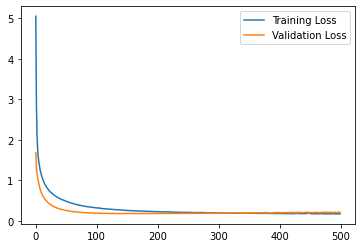

In [81]:
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.show()

#### Let's evaluate the prediction

In [83]:
y_pred = house.predict(Xtest_selected)

5/5 [==============================] - 0s 4ms/step


In [84]:
y_hat = std_label.inverse_transform(y_pred)

ytest_true = ytest['SalePrice'].values
ytrain_true =ytrain['SalePrice'].values

In [85]:
results = compute_rmsle(ytest_true, y_hat)
results

0.21

# Discussion
The RMSE I got from neural network model is not very good. The best value I got from training is 0.18 with different parameter setup of the model and feature selection. There might be a better way to model the relationship between the features and the target variable, or I can improve the performance of the model by using a different feature projection method.

The machine learning approach with gradient boosting is a simpler and better solution than the neural network approach for this task. It could be due to the fact that we have a very small number of samples whereas the neural network approach often requires a large number of samples to learn as there are more parameters that need to be tuned.